# Qubit characterization tests

In [1]:
import numpy as np
import qiskit.pulse as pulse
import qiskit.circuit as circuit
import functools
import tqcsf.file
import time

from qiskit.providers.tergite import Tergite
import qiskit.providers.tergite.template_schedules as templates
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging

In [2]:
chalmers = Tergite.get_provider()
backend = chalmers.get_backend("PinguOpenPulse")
backend.set_options(shots = 1500)
backend

TergiteBackend object @ 0x2338f002eb0:
  backend_name:               PinguOpenPulse
  backend_version:            2022.09.08
  n_qubits:                   5
  basis_gates:                ['rx', 'rz', 'delay', 'measure']
  gates:                      []
  local:                      False
  simulator:                  False
  conditional:                False
  open_pulse:                 True
  memory:                     False
  max_shots:                  inf
  coupling_map:               [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0]]
  dynamic_reprate_enabled:    False
  dt:                         1e-09
  dtm:                        1e-09
  parametric_pulses:          ['constant', 'zero', 'square', 'sawtooth', 'triangle', 'cos', 'sin', 'gaussian', 'gaussian_deriv', 'sech', 'sech_deriv', 'gaussian_square', 'drag']
  meas_levels:                (0, 1)
  characterized:              False

In [3]:
backend.calibration_table

,ro_dur_square,ro_amp_square,rabi_dur_gauss,rabi_sig_gauss,rabi_frequency,rabi_amplitude,rabi_phase,rabi_offset,ro_tof,ro_integration_time,qubit
0,0.000003,0.014,None,None,None,None,None,None,3.000000e-07,0.000003,1
1,0.000003,0.020,None,None,None,None,None,None,3.000000e-07,0.000003,2
2,0.000003,0.010,None,None,None,None,None,None,3.000000e-07,0.000003,3
3,0.000003,0.200,None,None,None,None,None,None,3.000000e-07,0.000003,4
4,0.000003,0.024,None,None,None,None,None,None,3.000000e-07,0.000003,5


In [4]:
QUBITS = ("q1", "q2", "q3", "q4", "q5")
# QUBITS = ("q5",)
QUBIT_IDXS = list(map(lambda QUBIT : int(QUBIT[1])-1, QUBITS))

In [5]:
resonator_freqs = {
    "q1": 6883895727.3990345,
    "q2": 6744891313.448814,
    "q3": 7029316180.018214,
    "q4": 7187190604.446356,
    "q5": 6660015449.656492,
}

VNA_qub_freqs = {
    'q1' : 5.8977e9, 
    'q2' : 6.109e9,  # I think this is the wrong peak
    'q3' : 6.0940e9,
    'q4' : 5.9500e9, 
    'q3c4' :7.3632e9, 
    'q5' : 5.0341e9  # has weird discontinuities?
}

# Resonator spec

In [6]:
frequencies = np.asarray([
    np.linspace(resonator_freqs[q] - 2e6, resonator_freqs[q] + 2e6, 260)
    for q in QUBITS
]).transpose()

In [7]:
param_sched = pulse.ScheduleBlock(name = f"res spec {QUBITS}")
freqs = [ circuit.Parameter(f"ro freq q{q}") for q in QUBIT_IDXS ]
for k,q in enumerate(QUBIT_IDXS):
    param_sched += pulse.SetFrequency(freqs[k], backend.measure_channel(q))
    
param_sched += templates.measure(backend, set(QUBIT_IDXS))

In [8]:
sweep = [ param_sched.assign_parameters(
    functools.reduce(lambda a, b: {**a, **b}, [{ p : f[i] } for i, p in enumerate(freqs) ]),
    inplace = False
) for f in frequencies ]

print("Total schedule count in sweep:", len(sweep))

Total schedule count in sweep: 260


In [9]:
# compile metadata about the sweep
qobj_header = {
    "tag": f"Resonator spectroscopy {QUBITS}",
    "sweep" : {
        "serial_order" : ("frequencies",),
        "parameters" : {
            "frequencies": {
                "long_name" : "Frequency of readout pulse",
                "unit" : "Hz",
                "slots" : { q : frequencies[:,k] for k,q in enumerate(QUBIT_IDXS) }
            }
        }
    }
}
job = backend.run(sweep, qobj_header = qobj_header, meas_level = 1)

Tergite: Job has been successfully submitted


In [10]:
while job.status != "DONE":
    time.sleep(5)
sf = tqcsf.file.StorageFile(job.logfile, mode = "r")

In [11]:
ds = sf.as_xarray()
ds

20220908-155510-894-58775e:   0%|          | 0/1300 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:             (frequencies/slot~0: 260, frequencies/slot~1: 260,
                         frequencies/slot~2: 260, frequencies/slot~3: 260,
                         frequencies/slot~4: 260)
Coordinates:
  * frequencies/slot~0  (frequencies/slot~0) float64 6.882e+09 ... 6.886e+09
  * frequencies/slot~1  (frequencies/slot~1) float64 6.743e+09 ... 6.747e+09
  * frequencies/slot~2  (frequencies/slot~2) float64 7.027e+09 ... 7.031e+09
  * frequencies/slot~3  (frequencies/slot~3) float64 7.185e+09 ... 7.189e+09
  * frequencies/slot~4  (frequencies/slot~4) float64 6.658e+09 ... 6.662e+09
Data variables:
    slot~0/acq~0        (frequencies/slot~0) complex128 (0.000840917334423456...
    slot~1/acq~0        (frequencies/slot~1) complex128 (-0.00332580781750393...
    slot~2/acq~0        (frequencies/slot~2) complex128 (0.003287555983293075...
    slot~3/acq~0        (frequencies/slot~3) complex128 (-0.00460130703779469...
    slot~4/acq~0        (frequencies/slot~4) complex128 (-0.00735963237048571...
Attributes:
    job_id:            93de091a-7136-4c96-8de6-f4d50ba5961b
    meas_level:        1
    meas_return:       1
    meas_return_cols:  1
    tuid:              20220908-155510-894-58775e

In [12]:
from analysis import plot_fit_functions as pff

C:\Users\Axel\Documents\Repositories\tergite-qiskit-connector\tests\analysis\plot_fit_functions.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


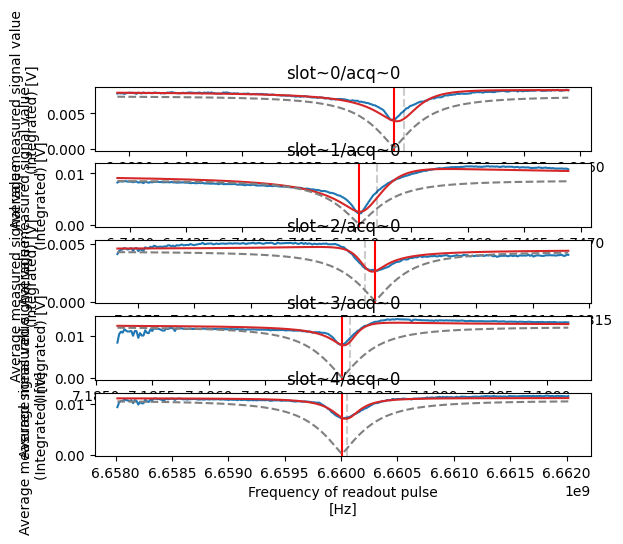

In [13]:
%matplotlib inline
data = pff.plot_fit_resonator(ds)

# Two tone

In [46]:
param_sched = pulse.ScheduleBlock(name = f"tt spec {QUBITS}")

stim_dur = 5000

freqs = [ circuit.Parameter(f"stim freq q{q}") for q in QUBIT_IDXS ]
amps = [ circuit.Parameter(f"stim amp q{q}") for q in QUBIT_IDXS ]

for k,(q,Q) in enumerate(zip(QUBIT_IDXS, QUBITS)):
    param_sched += pulse.SetFrequency(resonator_freqs[Q], backend.measure_channel(q))
    param_sched += pulse.SetFrequency(freqs[k], backend.drive_channel(q))
    param_sched += pulse.Play(pulse.Gaussian(
        stim_dur,
        amp = amps[k],
        sigma = stim_dur/5
    ), backend.drive_channel(q))
    # don't measure during excitation
    param_sched += pulse.Delay(stim_dur, backend.measure_channel(q), name = "Wait excite")
    param_sched += pulse.Delay(stim_dur, backend.acquire_channel(q), name = "Wait excite")
    
param_sched += templates.measure(backend, set(QUBIT_IDXS))    

In [36]:
frequencies = np.asarray([
    np.linspace(VNA_qub_freqs[Q] - 5e6, VNA_qub_freqs[Q] + 5e6, 120)
    for Q in QUBITS
]).transpose()
amplitudes = np.asarray([
    np.linspace(0, 1e-3, 10)
    for Q in QUBITS
]).transpose()

In [37]:
sweep = [ param_sched.assign_parameters(
    functools.reduce(lambda a, b: {**a, **b}, [({ p : f[i] } | { q : a[i] }) for i, p in enumerate(freqs) for q in amps ]),
    inplace = False
) for f in frequencies for a in amplitudes ]

print("Total schedule count in sweep:", len(sweep))

Total schedule count in sweep: 1200


In [42]:
# compile metadata about the sweep
qobj_header = {
    "tag": f"Qubit spectroscopy {QUBITS}",
    "sweep" : {
        "serial_order" : ("frequencies","amplitudes"),
        "parameters" : {
            "frequencies": {
                "long_name" : "Frequency of excitation pulse",
                "unit" : "Hz",
                "slots" : { q : frequencies[:,k] for k,q in enumerate(QUBIT_IDXS) }
            },
            "amplitudes": {
                "long_name" : "Amplitude of excitation pulse",
                "unit" : "V",
                "slots" : { q : amplitudes[:,k] for k,q in enumerate(QUBIT_IDXS) }
            }
        }
    }
}
job = backend.run(sweep, qobj_header = qobj_header, meas_level = 1)

Tergite: Job has been successfully submitted


In [43]:
while job.status != "DONE":
    time.sleep(5)
sf = tqcsf.file.StorageFile(job.logfile, mode = "r")

In [44]:
ds = sf.as_xarray()
ds

20220908-150800-762-e9b0ed:   0%|          | 0/6000 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:             (frequencies/slot~0: 120, amplitudes/slot~0: 10,
                         frequencies/slot~1: 120, amplitudes/slot~1: 10,
                         frequencies/slot~2: 120, amplitudes/slot~2: 10,
                         frequencies/slot~3: 120, amplitudes/slot~3: 10,
                         frequencies/slot~4: 120, amplitudes/slot~4: 10)
Coordinates:
  * amplitudes/slot~0   (amplitudes/slot~0) float64 0.0 0.0001111 ... 0.001
  * amplitudes/slot~1   (amplitudes/slot~1) float64 0.0 0.0001111 ... 0.001
  * amplitudes/slot~2   (amplitudes/slot~2) float64 0.0 0.0001111 ... 0.001
  * amplitudes/slot~3   (amplitudes/slot~3) float64 0.0 0.0001111 ... 0.001
  * amplitudes/slot~4   (amplitudes/slot~4) float64 0.0 0.0001111 ... 0.001
  * frequencies/slot~0  (frequencies/slot~0) float64 5.893e+09 ... 5.903e+09
  * frequencies/slot~1  (frequencies/slot~1) float64 6.104e+09 ... 6.114e+09
  * frequencies/slot~2  (frequencies/slot~2) float64 6.089e+09 ... 6.099e+09
  * frequencies/slot~3  (frequencies/slot~3) float64 5.945e+09 ... 5.955e+09
  * frequencies/slot~4  (frequencies/slot~4) float64 5.029e+09 ... 5.039e+09
Data variables:
    slot~0/acq~0        (frequencies/slot~0, amplitudes/slot~0) complex128 (-...
    slot~1/acq~0        (frequencies/slot~1, amplitudes/slot~1) complex128 (0...
    slot~2/acq~0        (frequencies/slot~2, amplitudes/slot~2) complex128 (-...
    slot~3/acq~0        (frequencies/slot~3, amplitudes/slot~3) complex128 (0...
    slot~4/acq~0        (frequencies/slot~4, amplitudes/slot~4) complex128 (0...
Attributes:
    job_id:            88a0c96f-52c5-4a6d-99a2-7581c4702187
    meas_level:        1
    meas_return:       1
    meas_return_cols:  1
    tuid:              20220908-150800-762-e9b0ed

<IPython.core.display.Javascript object>


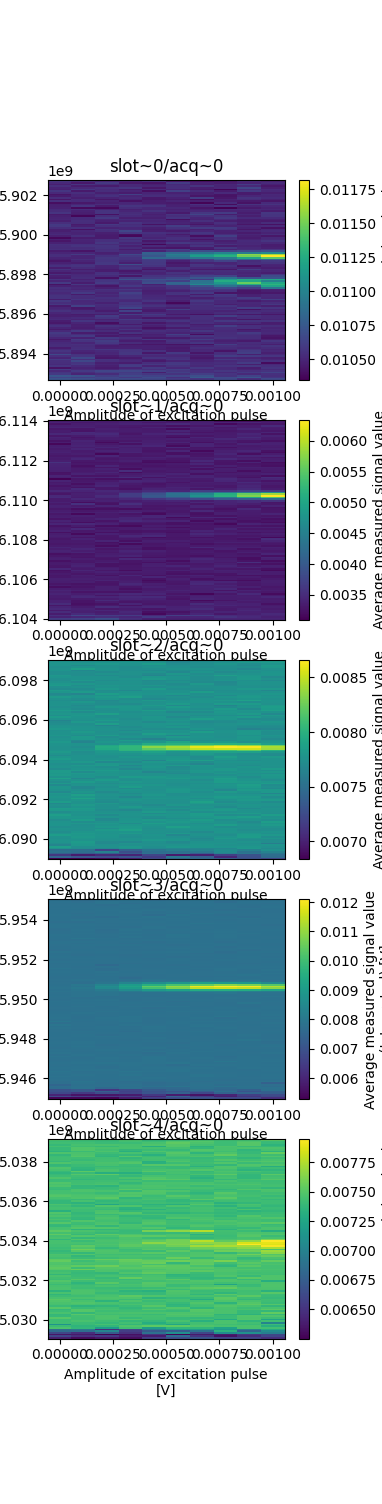

In [45]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(QUBITS), 1)
if len(QUBITS) == 1:
    axs = [axs]
    
for i,var in enumerate(ds):
    np.abs(ds[var]).plot(ax = axs[i])
    axs[i].set_title(var)